In [1]:
from flask import Flask, render_template, request, jsonify, Markup, url_for
#from wtforms import Form, validators
import sqlite3
import os 
import numpy as np
import json
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
import pandas as pd
from datetime import datetime , date, timedelta
from time import gmtime, strftime
from fottech_lib import instrumentservice
import project.data_preprocessing as dp
import script_sql.sqlite_populate as ssp
import torch
import torch.nn as nn
import torch.nn.functional as F

# scriptDirectory = os.path.join(os.path.dirname(__file__))
scriptDirectory = os.getcwd()

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update(mpl.rcParamsDefault)
%matplotlib inline

In [3]:

#Preparing the model
class AE(nn.Module):

    def __init__(self):
        super(AE, self).__init__()

        self.linear1 = nn.Linear(5, 20)
        self.linear2 = nn.Linear(20, 20)
        self.linear3 = nn.Linear(20, 1)

    def forward(self, x):
        x = self.linear1(x)
        x = F.tanh(x)
        x = self.linear2(x)
        x = F.tanh(x)
        x = self.linear3(x)
        return x
    
ae = AE()
ae.load_state_dict(torch.load(os.path.join(scriptDirectory,'model_objects/jiang_state_dict_model.pth')))


In [4]:
#Loading the indices
file_path = os.path.join(scriptDirectory,'data/universe_indices.npy')
universe_indices = np.load(file_path)

In [5]:
#Datetime
time_zone = strftime("%z", gmtime())
today = datetime.today()
today_time_exact = today.strftime("%d-%b-%Y %H:%M:%S")

In [6]:
#Preparing processed data
universe_indices_ric = []

In [7]:
B_to_R = instrumentservice.InstrumentService('prod','APAC')
for index in universe_indices:
    index_ric = B_to_R.transcode(index, target='reuter', partial_match=False)

    if(index_ric != None):
        ric = index_ric[1:]
        universe_indices_ric.append(ric)

In [8]:
dictionary = dp.get_repo_schedules_universe(universe_indices_ric,'latest')

############################## Index FCHI ##############################
############################## Index GDAXI ##############################
############################## Index FTSE ##############################
############################## Index STOXX50 ##############################
############################## Index STOXX50E ##############################
############################## Index AEX ##############################
############################## Index IBEX ##############################
############################## Index NDX ##############################
############################## Index SXKE ##############################
############################## Index SPX ##############################
############################## Index SX7E ##############################
############################## Index N225 ##############################
############################## Index SSMI ##############################
############################## Index DJI #####

############################## Index dMICA00000NUS ##############################
############################## Index FTJ400 ##############################
############################## Index AXJOA ##############################
############################## Index dMILA00000NUS ##############################
############################## Index dMINA00000GUS ##############################
############################## Index dMIPC00000GUS ##############################
############################## Index RUTTR ##############################
############################## Index MIWD00000PUS ##############################
############################## Index IXT ##############################
############################## Index SPXV ##############################
############################## Index dMINZ00000NUS ##############################
############################## Index dMICA00000GUS ##############################
############################## Index dMIWD00000GUS ########

############################## Index dMIPK00000NUS ##############################
############################## Index MIPCJ0000NUS ##############################
############################## Index TFTFVTTU ##############################
############################## Index SXLV1T ##############################
############################## Index dMIEUS000mPEU ##############################
############################## Index dMIWS0000mPUS ##############################
############################## Index dMIMS00000GUS ##############################
############################## Index dMIWS0000mPEU ##############################
############################## Index MITW00000NUS ##############################
############################## Index TOPXDVNET ##############################
############################## Index SGESGSEP ##############################
############################## Index dMISAPz000NUS ##############################
############################## Index dM

In [9]:
file_path = os.path.join(scriptDirectory,'output/universe_repo_processed.json')

In [10]:
try:
    with open(file_path, 'w') as fp:
        json.dump(dictionary, fp)
    print('file saved')
except:
    print('For some reasons, the file couldnt be saved')

file saved


In [11]:
#cleaning the data
path_to_processed_data = os.path.join(scriptDirectory,'output/universe_repo_processed.json')
path_to_cleaned_data = os.path.join(scriptDirectory,'output/universe_repo_cleaned.json')
dp.cleaning_data_universe_Jiang(path_to_processed_data,path_to_cleaned_data)

################## Cleaning Repos for Universe indices Jiang ##################
file saved


In [12]:
#Loading the database
with open(path_to_cleaned_data) as json_file:
	dictionary_cleaned = json.load(json_file)

In [13]:
#Prediction
indices_repo = list(dictionary_cleaned.keys())
indices_ric = ['.'+_ for _ in indices_repo]
indices_dt = [B_to_R.transcode(_, target='description', partial_match=False) for _ in indices_ric]
indices_mnemo = [B_to_R.transcode(_, target='bloomberg', partial_match=False) for _ in indices_ric]

In [14]:
time_series = np.array(list(dictionary_cleaned.values()))[:,0]
repo = np.array(list(dictionary_cleaned.values()))[:,1]
dates_repo = np.array(list(dictionary_cleaned.values()))[:,2]
dates_repo = [datetime(int(_[:4]),int(_[5:7]),int(_[8:])).strftime("%d-%b-%Y") for _ in dates_repo]

In [15]:
class Attrib_test(nn.Module):
    
    def __init__(self):
        
        super (Attrib_test, self).__init__()
        self.attrib = nn.Parameter(torch.zeros([len(indices_repo), 4]), requires_grad = True)
    def forward(self, x):
        return self.attrib

In [16]:
attrib_test = Attrib_test()

optimizer = torch.optim.Adam(list(attrib_test.parameters()), lr=1e-1)


In [17]:
for k in range(len(indices_repo)):        
    res = torch.Tensor([0.])
    # for _ in range(200):
    for _ in range(100):
        res_ = []
        for x,y in zip(time_series[k],repo[k]):
            if x>90:
                res_.append((ae(torch.cat([torch.Tensor([x/252.0]),attrib_test.attrib[k,:]]))[0] - y)**2)
        res = torch.mean(torch.stack(res_))

        optimizer.zero_grad()
        res.backward()
        optimizer.step()

    if k % 50 ==0:
        print(k,'/',len(indices_repo))



0 / 129
50 / 129
100 / 129


In [18]:
repo_decoded =[]        
for k in range(len(indices_repo)):
    pred = []
    for x in time_series[k] :
        if x>=90:
            pred.append((ae(torch.cat([torch.Tensor([x/252.0]),attrib_test.attrib[k,:]])).detach().numpy())[0])
    repo_decoded.append(pred)        


In [19]:
#RMSES
rmses_repo = []
max_error = []
for i in range(len(repo)):
    try:
        repo_cleaned = np.array(repo[i])
        repo_cleaned = repo_cleaned[np.array(time_series[i])>=90]
        # rmses_repo.append(np.sqrt(mean_squared_error(repo[i] ,repo_decoded[i])/len(time_series[i])))
        rmses_repo.append(min(np.sqrt(mean_squared_error(repo_cleaned, repo_decoded[i])),.2))
        max_error.append(min(np.max(np.abs(repo_cleaned - np.array(repo_decoded[i])))/(max(np.max(repo_cleaned)-np.min(repo_cleaned),0.01)),1))
    except:
        rmses_repo.append(0.)
        max_error.append(0.)




In [20]:
#And now we round the values
repo_decoded = [[float(_) for _ in inner] for inner in repo_decoded]
rmses_repo = np.array(rmses_repo)
# rmses_repo = np.round_(rmses_repo, decimals=3)
#rmses_forwards = [_**2 for _ in rmses_forwards]
 
# seuil = 0.1
# outliers_indices = [_ for _ in range(len(indices_dt)) if(rmses_repo[_] > seuil)]
# # outliers_indices = [_ for _ in range(len(indices_dt)) if(max_error[_] > seuil)]
# MSE_outliers = rmses_repo[outliers_indices]
# accurate_indices = [_ for _ in range(len(indices_dt)) if(_ not in outliers_indices)]
# MSE_accurate = rmses_repo[accurate_indices]

In [21]:
if len(indices_dt) > 20:
    #KMeans to determine the threshold
    df = pd.DataFrame(rmses_repo)
    kmeans = KMeans(n_clusters=2).fit(df)
    outliers_indices = np.where(kmeans.labels_==0)[0]
    if(len(outliers_indices) >= (len(kmeans.labels_)-len(outliers_indices))):
        outliers_indices = np.where(kmeans.labels_==1)[0]
    MSE_outliers = rmses_repo[outliers_indices]
    accurate_indices = [_ for _ in range(len(indices_dt)) if(_ not in outliers_indices)]
    MSE_accurate = rmses_repo[accurate_indices]
    seuil = (np.max(MSE_accurate) + np.min(MSE_outliers)) /2
else:
    seuil = 0.1
    outliers_indices = [_ for _ in range(len(indices_dt)) if(rmses_repo[_] > seuil)]
    accurate_indices = [_ for _ in range(len(indices_dt)) if(_ not in outliers_indices)]


# ==========================================================================================
app = Flask(__name__)


@app.route('/', methods=['GET', 'POST'])
def main():
    return render_template("template.html",
        universe_indices=universe_indices,
        len_universe_indices=len(universe_indices),
        indices_repo=indices_dt,
        len_indices_repo=len(indices_dt),
        indices_mnemo=indices_mnemo,
        indices_ric=indices_ric,
        repo=repo,
        repo_json=json.dumps(repo.tolist()),
        repo_decoded=repo_decoded,
        repo_decoded_json=json.dumps(repo_decoded),
        rmses_repo=rmses_repo,
        rmses_repo_json=json.dumps(rmses_repo.tolist()),
        labels=json.dumps(time_series.tolist()),
        outliers_indices=outliers_indices,
        len_outliers_indices=len(outliers_indices),
        accurate_indices=accurate_indices,
        len_accurate_indices=len(accurate_indices),
        seuil=seuil,
        time_zone=time_zone,
        today_time_exact=today_time_exact,
        dates_repo=dates_repo)


@app.route('/stop', methods=['GET', 'POST'])
def shutdown():
    func = request.environ.get('werkzeug.server.shutdown')
    if func is None:
        raise RuntimeError('Not running with the Werkzeug Server')
    func()
    return 'Server shutting down...'

app.run(host='0.0.0.0',  port=8000, threaded=True)

In [22]:
len(repo_decoded)

129

In [23]:
len(repo)

129

In [24]:
len(dates_repo)

129

In [25]:
plt.rcParams['axes.facecolor'] = 'white'

In [67]:
def plotCurve(dataSerieOriginal, dataSerieInterpolated, title):
    refSize=5
    plt.plot(dataSerieOriginal, 'o')
    plt.plot(dataSerieInterpolated)
    plt.xlabel("Maturity (Year)", fontsize=2*refSize, labelpad=3*refSize)
    plt.ylabel("Rate (%)", fontsize=2*refSize, labelpad=3*refSize)
    plt.tick_params(axis='x', labelsize=2*refSize, pad=int(refSize/2))
    plt.tick_params(axis='y', labelsize=2*refSize, pad=int(refSize/2))
    plt.title(title, fontsize = 2*refSize)
    plt.show()

In [41]:
time_series.shape

(129,)

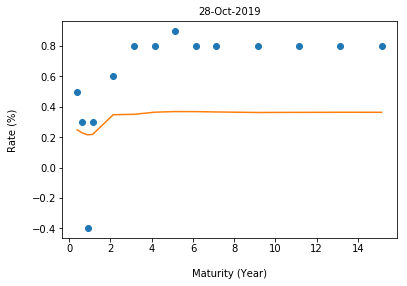

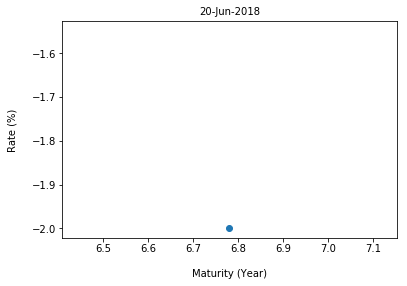

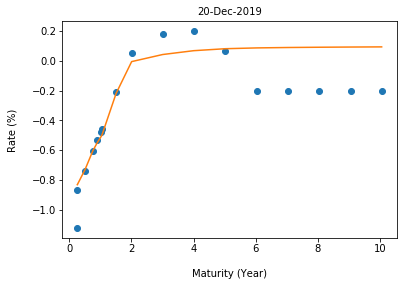

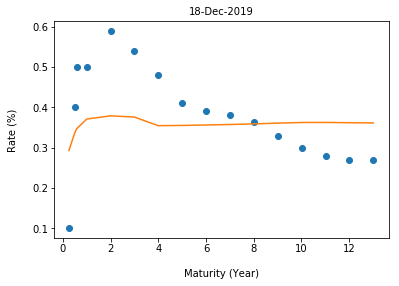

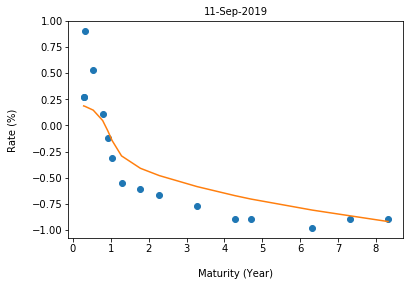

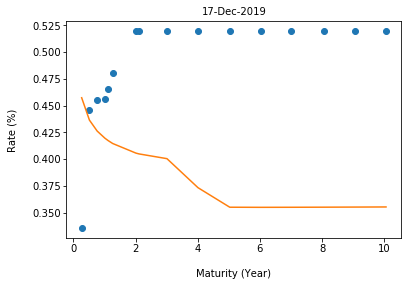

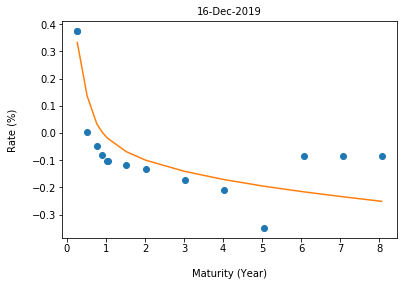

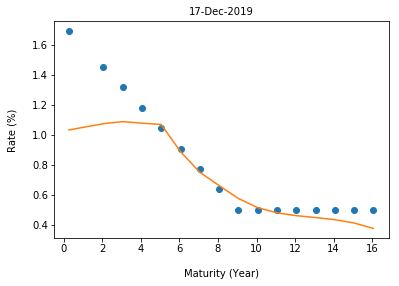

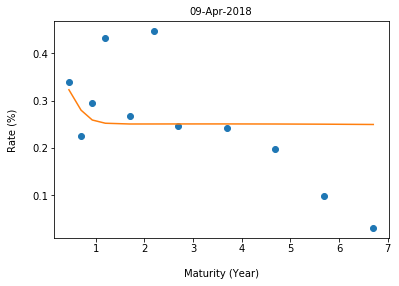

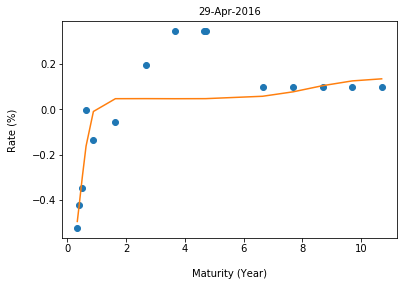

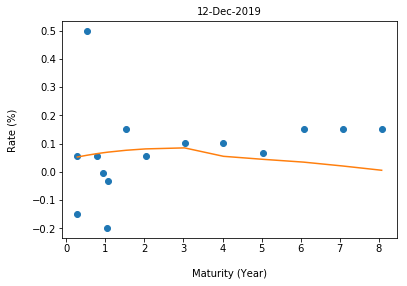

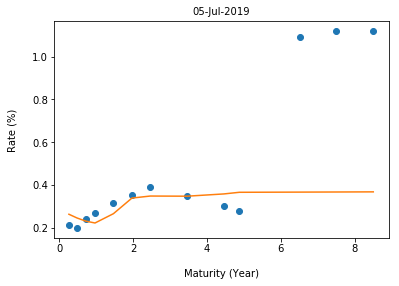

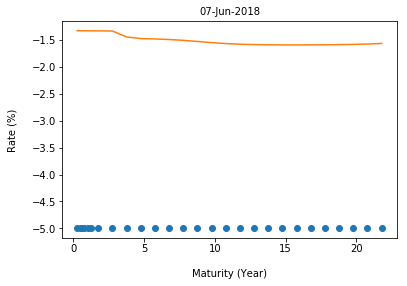

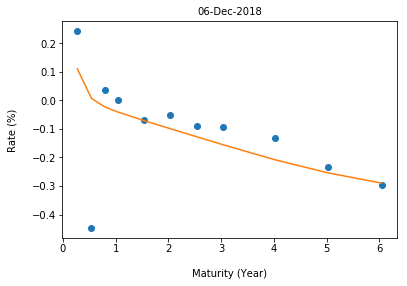

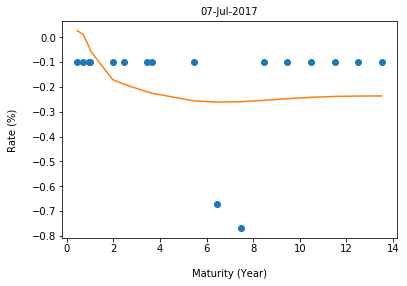

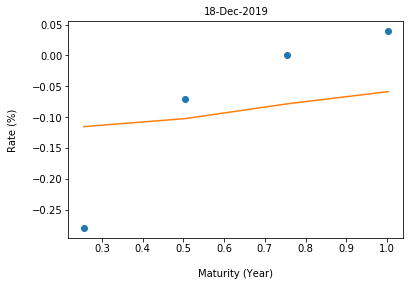

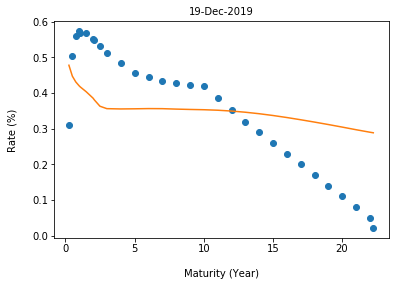

In [42]:
#plot outliers
for k in outliers_indices:
    date = time_series[k]
    repoCurve = repo[k]
    pred = repo_decoded[k]
    #plt.figure()
    sCleaned = pd.Series(pred, 
                         index = list(map(lambda x : x/365, 
                                          list(filter(lambda x: x >= 90, date)))) )
    sOrigin = pd.Series([repoCurve[x] for x in range(len(repoCurve)) if 90 <= date[x]], 
                        index = list(map(lambda x : x/365, 
                                         list(filter(lambda x: x >= 90, date)))) )
    plotCurve(sOrigin,sCleaned, dates_repo[k])

In [43]:
#max_error
#filter
#%matplotlib

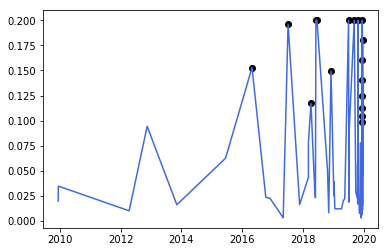

In [44]:
#plot rmses and outliers points
sRMSE = pd.Series(rmses_repo, index = [datetime.strptime(d , '%d-%b-%Y') for d in dates_repo ])
sOutlier = pd.Series([rmses_repo[i] for i in outliers_indices ], 
                     index = [datetime.strptime(dates_repo[i] , '%d-%b-%Y') for i in outliers_indices ])
plt.plot(sOutlier.sort_index(), 'o', color='k')
plt.plot(sRMSE.sort_index(), color='royalblue')
plt.show()

In [45]:
inLiers = list(filter(lambda x: rmses_repo[x] <= 0.01, range(len(rmses_repo))))

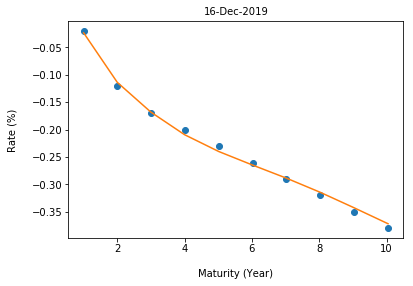

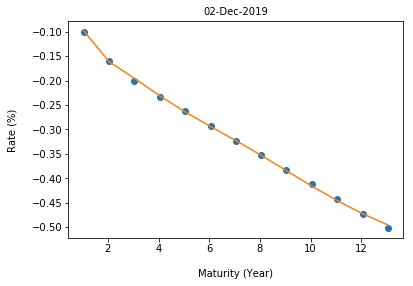

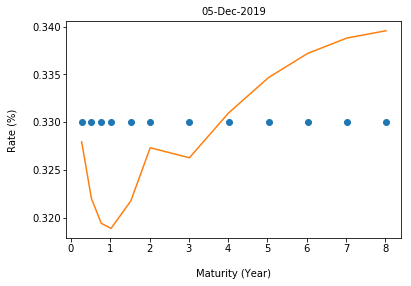

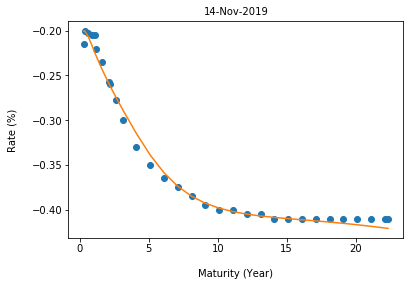

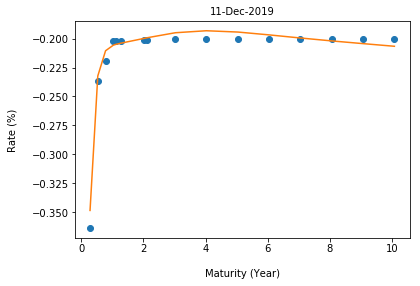

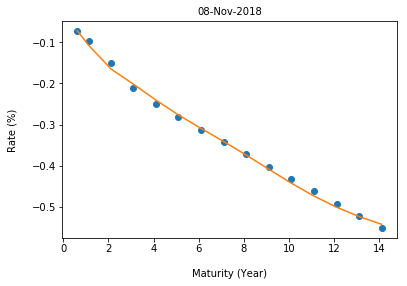

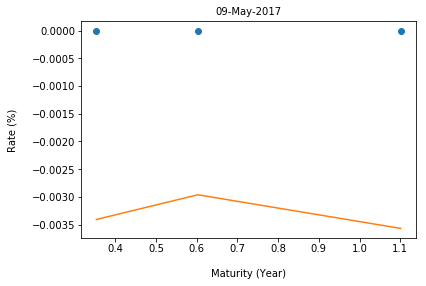

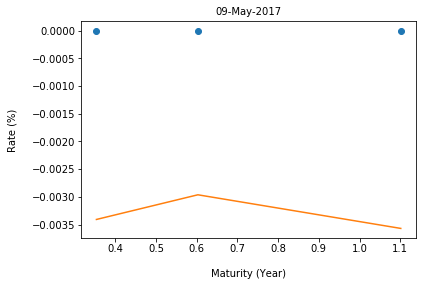

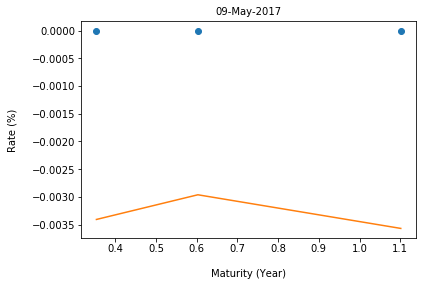

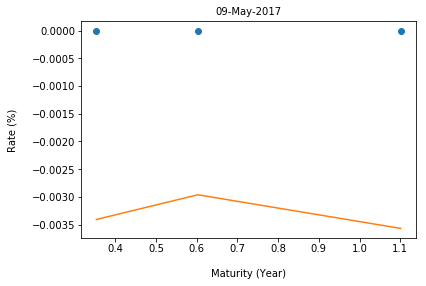

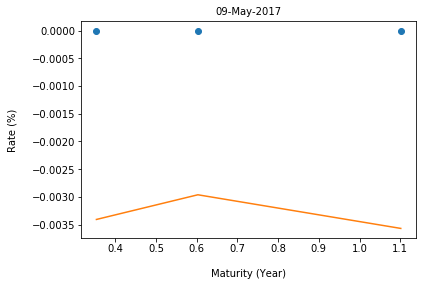

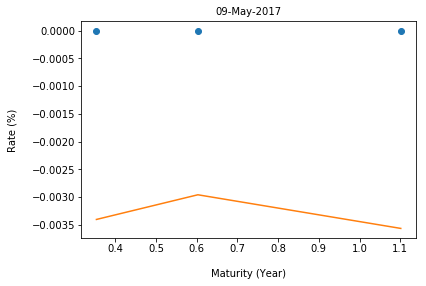

In [46]:
#plot inliers
for k in inLiers:
    date = time_series[k]
    repoCurve = repo[k]
    pred = repo_decoded[k]
    sCleaned = pd.Series(pred, 
                         index = list(map(lambda x : x/365, 
                                          list(filter(lambda x: x >= 90, date)))) )
    sOrigin = pd.Series([repoCurve[x] for x in range(len(repoCurve)) if 90 <= date[x]], 
                        index = list(map(lambda x : x/365, 
                                         list(filter(lambda x: x >= 90, date)))) )
    plotCurve(sOrigin,sCleaned, dates_repo[k])

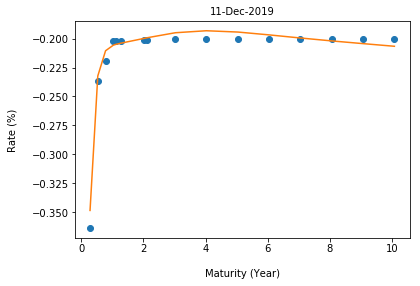

In [52]:
ind1 = inLiers[4]
date1 = time_series[ind1]
repoCurve1 = repo[ind1]
pred1 = repo_decoded[ind1]
sCleaned1 = pd.Series(pred1, 
                      index = list(map(lambda x : x/365, 
                                       list(filter(lambda x: x >= 90, date1)))) )
sOrigin1 = pd.Series([repoCurve1[x] for x in range(len(repoCurve1)) if 90 <= date1[x]], 
                     index = list(map(lambda x : x/365, 
                                      list(filter(lambda x: x >= 90, date1)))) )
plotCurve(sOrigin1,sCleaned1, dates_repo[ind1])

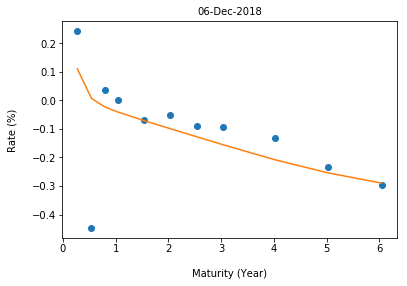

In [51]:
ind2 = outliers_indices[13]
date2 = time_series[ind2]
repoCurve2 = repo[ind2]
pred2 = repo_decoded[ind2]
sCleaned2 = pd.Series(pred2, 
                      index = list(map(lambda x : x/365, 
                                       list(filter(lambda x: x >= 90, date2)))) )
sOrigin2 = pd.Series([repoCurve2[x] for x in range(len(repoCurve2)) if 90 <= date2[x]], 
                     index = list(map(lambda x : x/365, 
                                      list(filter(lambda x: x >= 90, date2)))) )
plotCurve(sOrigin2,sCleaned2, dates_repo[ind2])

In [62]:
date3 = [0.334247,    
         0.583562,   
         1.082192,   
         2.079452,   
         3.076712,    
         4.073973,    
         5.090411,    
         6.087671,    
         7.084932,    
         9.076712,    
         11.093151,   
         15.093151]   
repoCurve3 = [-0.39,
              -0.43,
              -0.45,
              -0.47,
              -0.49,
              -0.49,
              -0.49,
              -0.49,
              -0.49,
              -0.49,
              -0.49,
              -0.50]
pred3 = [-0.389610,
         -0.432510,
         -0.458510,
         -0.477504,
         -0.483631,
         -0.484594,
         -0.484436,
         -0.484704,
         -0.485662,
         -0.488890,
         -0.492566,
         -0.498653]

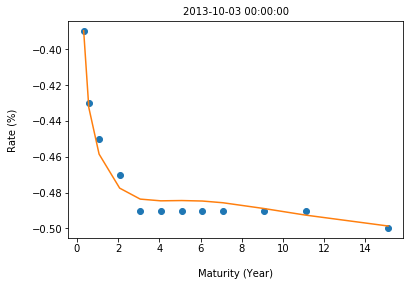

In [68]:
sCleaned3 = pd.Series(pred3, index = date3 )
sOrigin3 = pd.Series(repoCurve3, index = date3 )
plotCurve(sOrigin3,sCleaned3, datetime(2013, 10, 3, 0, 0))

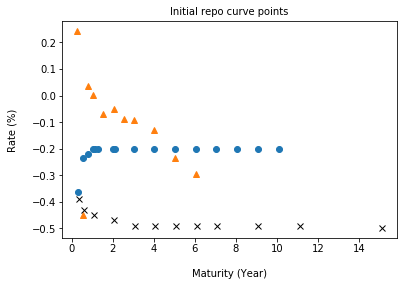

In [76]:
refSizeMulti=5
plt.plot(sOrigin1, 'o')
plt.plot(sOrigin2, '^')
plt.plot(sOrigin3, 'kx')
plt.xlabel("Maturity (Year)", fontsize=2*refSizeMulti, labelpad=3*refSizeMulti)
plt.ylabel("Rate (%)", fontsize=2*refSizeMulti, labelpad=3*refSizeMulti)
plt.tick_params(axis='x', labelsize=2*refSizeMulti, pad=int(refSizeMulti/2))
plt.tick_params(axis='y', labelsize=2*refSizeMulti, pad=int(refSizeMulti/2))
plt.title("Initial repo curve points", fontsize = 2*refSizeMulti)
plt.show()